In [7]:
from basic_op_jup import *
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cdo import Cdo
import bottleneck as bk
import pandas as pd
cdo=Cdo()

In [10]:
file_in_prec = '~/work/jacopo/DATA/ERA5_prec_day_HKKH.nc'
region_prec = cdo.sellonlatbox(78, 93, 25, 32, input = file_in_prec)

prec = xr.open_dataset(region_prec)

to_base = prec.tp.sel(time=slice("1950-01-01", "1980-01-01"))
to_proj = prec.tp.sel(time=slice("1950-01-01", "1955-01-04"))

<xarray.DataArray 'tp' (time: 25871, lat: 29, lon: 61)>
array([[[8.91489163e-02, 5.94447665e-02, 4.70974855e-02, ...,
         7.57329617e-05, 8.97575810e-05, 7.01231111e-05],
        [1.14070669e-01, 8.21169689e-02, 4.57427092e-02, ...,
         6.73181858e-05, 1.29026521e-04, 8.97575810e-05],
        [1.16269730e-01, 9.85061377e-02, 6.20280989e-02, ...,
         3.92689435e-05, 1.06587126e-04, 8.13428051e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.98588660e-03, 4.72910237e-03, 6.00814819e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.45132604e-05, 1.89332408e-03, 2.91431649e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.12196976e-05, 1.40246229e-05, 1.23416685e-04]],

       [[3.40342522e-03, 3.75111890e-03, 4.66704369e-03, ...,
         1.02519989e-03, 1.34905172e-03, 1.33117032e-03],
        [5.53329755e-03, 5.76972961e-03, 4.15245723e-03, ...,
         1.06493640e-03, 1.23580289e-03, 1.15831685e-03],
        [5.68230916e-03, 5.57899475e-03, 3.95576190e-03, ...,
         7.60952593e-04, 8.06649507e-04, 6.93400740e-04],
...
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[3.27825546e-04, 3.07957351e-04, 2.76168168e-04, ...,
         1.98682164e-06, 1.98682164e-06, 1.19209290e-05],
        [1.60932541e-04, 1.50998443e-04, 3.55641067e-04, ...,
         1.98682164e-06, 1.98682164e-06, 5.56310006e-05],
        [7.94728658e-06, 1.70866639e-04, 3.73522460e-04, ...,
         0.00000000e+00, 3.97364329e-06, 9.33806150e-05],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T15:00:00 ... 2020-12-31T11:30:00
  * lon      (lon) float64 78.0 78.25 78.5 78.75 79.0 ... 92.25 92.5 92.75 93.0
  * lat      (lat) float64 32.0 31.75 31.5 31.25 31.0 ... 25.75 25.5 25.25 25.0

In [4]:
eof, pc, exp_var, solver = eof_base(to_base = to_base, weights = None, center = True, ddof = 1, eofscaling = 0, pcscaling = 0, n_comp = 3)
pc_projection = eof_project(solver, to_proj, 3)

array([[ 0.00541986,  0.00039907, -0.00033974],
       [-0.00874257, -0.00234997,  0.00182069],
       [-0.02869583,  0.00501667, -0.00351908]], dtype=float32)

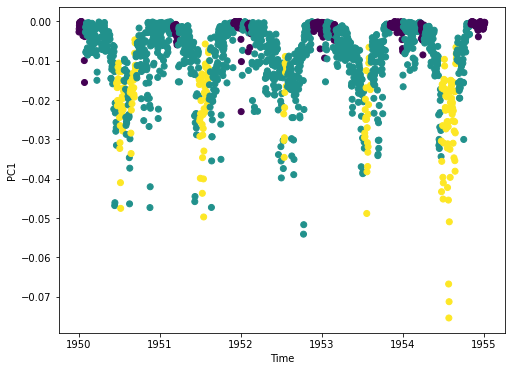

In [5]:
training_set_0 = pc.to_numpy()
train_mvm = bk.move_mean(training_set_0, window = 30, axis = 0)
train_mvm[np.isnan(train_mvm)] = 0
training_set = train_mvm
#training_set = np.concatenate((training_set_0, train_mvm), axis = 1)

test_set_0 = pc_projection.to_numpy()
test_mvm = bk.move_mean(test_set_0, window = 30, axis = 0)
test_mvm[np.isnan(test_mvm)] = 0
test_set = test_mvm
#test_set = np.concatenate((test_set_0, test_mvm), axis = 1)

#training_set = training_set/np.std(training_set_0, axis = 0)
#test_set = test_set/np.std(test_set, axis = 0)

model, clust_centers = kmean_training(training_set_0, 3, 300)
prediction = kmean_preditting(model, test_set)

fig = plt.figure(figsize=(8, 6))
plt.scatter(pc_projection.time, pc_projection.sel(mode=0), c = prediction)
plt.ylabel('PC1')
plt.xlabel('Time')

clust_centers

In [8]:
yr = pc_projection['time.year'].to_numpy()
dd = gregorian_day(pc_projection)

bb = pd.DataFrame(np.transpose(np.vstack((prediction,yr,dd))))

bb.columns = ['idx', 'yr', 'dd']
trend = bb.groupby(["yr",'idx']).mean()
trend_st = bb.groupby(["yr",'idx']).std()

#plt.scatter(trend.reset_index()['yr'], trend.reset_index()['dd'], c=trend.reset_index()['idx'])


NameError: name 'gregorian_day' is not defined

In [9]:
trend_np = np.array(trend.reset_index())
trend_st_np = np.array(trend_st.reset_index())

to_plot = trend_np[trend_np[:,1]==1] 
to_plot_err =  trend_st_np[trend_st_np[:,1]==1] 


plt.errorbar(to_plot[:,0], to_plot[:,2], yerr = to_plot_err[:,2], lw = 3, elinewidth = 1.5, c = 'r', ecolor = 'b')
plt.title('Time evolution of monsoon-like season - HKK')

NameError: name 'trend' is not defined

In [23]:
dd

array([1, 2, 3, ..., 2, 3, 5])

In [24]:
print(pc_projection['time'])

<xarray.DataArray 'time' (time: 3656)>
array(['1950-01-01T15:00:00.000000000', '1950-01-02T11:30:00.000000000',
       '1950-01-03T11:30:00.000000000', ..., '1960-01-02T11:30:00.000000000',
       '1960-01-03T11:30:00.000000000', '1960-01-04T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T15:00:00 ... 1960-01-04T11:30:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T
